In [1]:
def lasso_regress(comp_df, y):
    alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 10, 100, 1000, 10000, 100000]
    model_cv = LassoCV(alphas = alphas).fit(comp_df.to_numpy(), y)
    
    m = Lasso(alpha = model_cv.alpha_, fit_intercept=False).fit(comp_df.to_numpy(), y) # ...??
    return m.predict(comp_df.to_numpy())

def ridge_regress(comp_df, y):
    alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 10, 100, 1000, 10000, 100000]
    model_cv = RidgeCV(alphas = alphas).fit(comp_df.to_numpy(), y)
    m = Ridge(alpha = model_cv.alpha_, fit_intercept=False).fit(comp_df.to_numpy(), y) # ...??
    return m.predict(comp_df.to_numpy())

def scale(features):  # 행렬 x를 만드는 과정 스케일링하는 함수
    for i in range(features.shape[1]):
        f = features.iloc[:, i].copy()
        features.iloc[:, i] = f / LA.norm(f)  # linear algebra norm() = 벡터의 길이 계산
    return features

def z_scale(feature):
    f = feature.copy()
    feature = (f - np.mean(f))/np.std(f)
    return feature

def mase(a, b):  # Mean Absolute Scale Error
    a = z_scale(a)
    b = z_scale(b)
    return np.mean(np.abs(a - b))

def rmse(a, b):  # Mean Absolute Scale Error
    RMSE = mean_squared_error(a, b)**0.5
    return RMSE

def forward_stepwise(p_k_features, res):
    n = len(res)
    p = p_k_features.shape[1]
    p_k_features = scale(p_k_features)
    idx = np.argmax([np.abs(np.dot(p_k_features.iloc[:, i], res)) for i in range(p)])    
    return p_k_features.columns[idx], p_k_features.iloc[:,idx]


# train set feature 순으로 test set feature 적용
def forward_stepwise_sort(p_k_features, res):
    n = len(res)
    p = p_k_features.shape[1]
    p_k_features = scale(p_k_features)
    idx = np.argmax(np.abs(np.dot(p_k_features.iloc[:,0], res)))  
    return p_k_features.columns[idx], p_k_features.iloc[:,idx]


def make_fs_df(dsy, extfeature):
    comp = OrderedDict()
    # add basic components
    comp['lin'] = LinearTrend()
    seasonalities = {}
    comp['w'] = FourierSeasonality(7, 3)
    comp['m'] = FourierSeasonality(30.4375, 5)
    comp['y'] = FourierSeasonality(365.25, 10)

    dsy = dsy.loc[dsy['ds'].isin(extfeature['ds'])]
    extfeature = extfeature.loc[extfeature['ds'].isin(dsy['ds'])]
    
    #add custom features
    """for f in extfeature.columns[1:]:
        print(extfeature.loc[:, f].shape)
        comp[f] = DataFrameRegressor(z_scale(extfeature.loc[:, f]), name=f"ER-{f}")"""
    for f in extfeature.columns[1:]:
        ds_frame = extfeature.copy().loc[:, ["ds", f]]
        ds_frame[f] = (ds_frame[f] - np.mean(ds_frame[f])) / np.std(ds_frame[f])  # scale 괄호 추가
        comp[f"{f}"] = DataFrameRegressor(ds_frame, name=f"{f}")
    #comp[f"extfeature-{}"] = DataFrameRegressor(extfeature, name="extfeatures")
    
    m = LinearRidgeModel([*comp.values()])  # values should have been passed in the same order as the dict
    m.fit(dsy)
    augmented = dsy.copy()
    df = pd.DataFrame({
            'ds': pd.to_datetime(augmented['ds']),
            't': m.t_scaler.fit_transform(augmented[['ds']].apply(pd.to_datetime)).flatten(),
            'y': m.y_scaler.fit_transform(augmented[['y']]).flatten(),
        })
    return m.get_features(df)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA
import os
import sys
sys.path.append("/home/dashadower/git_repos/aria")
from aria.models.pooling import PoolingModel
from math import log
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
import scipy.stats as ss
from aria.components.fourier_seasonality import FourierSeasonality
from aria.components.linear_trend import LinearTrend
from aria.components.dataframe_regressor import DataFrameRegressor
from aria.models.linear_ridge import LinearRidgeModel
from sklearn.preprocessing import PowerTransformer
from fbprophet import Prophet
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
# import os
# failure_df = pd.read_csv(os.path.realpath('failures.csv')).set_index('age')
# u = np.nanmean(failure_df.values.flatten())
# s = np.sqrt(np.nanvar(failure_df.values.flatten()))
# failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
# engine_df = pd.read_csv(os.path.realpath('engine.csv')).set_index('ship')

# test_failure_df = pd.read_csv(os.path.realpath('../data/failure_count_test.csv')).set_index('age')
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
# test_engine_df = pd.read_csv(os.path.realpath('../data/engine_test.csv')).set_index('ship')

In [4]:
# # power transformer


# failure_df = pd.read_csv('failure_count2.csv').set_index('age')
# engine_df = pd.read_csv('engine2.csv').set_index('ship')
# test_failure_df = pd.read_csv('failure_count_test.csv').set_index('age')
# test_engine_df = pd.read_csv('engine_test.csv').set_index('ship')

# pt = PowerTransformer()
# pt.fit(failure_df)
# failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
# pt.fit(test_failure_df)
# test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

# engine_df.engine.value_counts()

In [5]:
# y_bar_prophet = []
# for i in range(1, 2):
#     ships = engine_df.index[engine_df['engine'] == i]
# #     y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
#     print(failure_df[ships].mean(axis=1).values)
# y_bar_prophet = np.array(y_bar_prophet).transpose()

## G-Prophet

In [40]:
failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')

# test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
# test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')


# power transform
# pt = PowerTransformer()
# pt.fit(failure_df)
# failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
# pt.fit(test_failure_df)
# test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

In [44]:
%%time
# 데이터 2개 이하는 prophet 불가
# type1 제외 : s4
# type2 제외 : s7,s10,s16
# type3 제외 : s60
# type4 제외 : s88, s92, s95
from fbprophet import Prophet

def predict_prophet(s):
    ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
    training_df = pd.DataFrame({'ds': ds, 'y': s})
    m = Prophet()
    m.fit(training_df)
    predict_df = pd.DataFrame({'ds': ds})
    return m.predict(predict_df)['trend'],m.predict(predict_df)['yearly'],m.stan_backend.stan_fit['sigma_obs'],m.predict(predict_df)['yhat']

y_zero_prophet = predict_prophet(failure_df.mean(axis=1).values)
y_bar_prophet = []
y_prophet = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
    for j in range(0,len(ships)):
        y_prophet.append(predict_prophet(failure_df[ships[j]].values))
        print(ships[j])


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run 

s1


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s2


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s3


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


s5


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


s6


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s8


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s9


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s11


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s12


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s13


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s14


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s15


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s17


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


s18


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s19


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s20


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


s21


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


s22


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s23


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s24


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


s25


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s26


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s27


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s28


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s29


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


s30


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


s31


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


s32


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


s33


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s34


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s35


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


s36


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s37


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s38


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s39


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s40


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s41


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s42


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


s43


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s44


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s45


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s46


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s47


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s48


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s49


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s50


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s51


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s52


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s53


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s54


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s55


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s56


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s57


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s58


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s59


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s61


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


s62


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s63


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s64


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s65


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s66


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s67


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s68


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s69


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s70


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s71


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s72


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s73


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


s74


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s75


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s76


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s77


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s78


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s79


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s80


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s81


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s82


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s83


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s84


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s85


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s86


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


s87


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s89


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


s90


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


s91


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s93


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s94


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


s96


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


s97


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


s98
s99
CPU times: user 5min 20s, sys: 1.36 s, total: 5min 21s
Wall time: 5min 21s


In [163]:
##### layer3 train ELPD

failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')
test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')

# standard scale
u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)

## power transform
# pt = PowerTransformer()
# pt.fit(failure_df)
# failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
# pt.fit(test_failure_df)
# test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)


from scipy.stats import norm
margin_sum = []
margin =[]
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]

# for i in range(0,len(y_prophet)):
for i in range(0,91):
    if i < 5:
        j = 0
    elif i < 29:
        j=1
    elif i < 71:
        j=2
    elif i < 87:
        j=3
    elif i >= 87:
        j=4    

    wy = 1/y_prophet[i][2]**2          # 1/layer3 sigma_obs
    wy_bar = 1/y_bar_prophet[j][2]**2  # 1/layer2 sigma_obs
    wy_zero = 1/y_zero_prophet[2]**2   # 1/layer1 sigma_obs
    wy_sum = wy + wy_bar + wy_zero

#     wy = y_prophet[i][0]**2          # 1/layer3 sigma_obs
#     wy_bar = y_bar_prophet[j][0]**2  # 1/layer2 sigma_obs
#     wy_zero = y_zero_prophet[0]**2   # 1/layer1 sigma_obs
#     wy_sum = wy + wy_bar + wy_zero
        
    y_mu = ((y_prophet[i][0] * ((wy) / (wy_sum))) +          # layer3
            (y_bar_prophet[j][0] * ((wy_bar) / (wy_sum))) +  # layer2
             (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) +  # layer1
            y_prophet[i][1])  # y_prophet[i][1] : layer3 seasonality(yearly)
    
#     y_mu = (y_prophet[i][0]) + y_prophet[i][1]
    
    new_y.append(y_mu)
    y_sigma = y_prophet[i][2] # layer3 sigma_obs
    
    y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_mu}).dropna()
#     y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_prophet[i][3]}).dropna()

    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2.y, y_mu2.yhat, y_sigma)
#     print(f'{i}', np.mean(margin_lik))
    margin_sum.append(np.mean(margin_lik))
#     margin.append(np.mean(margin_sum))    

margin = [x for x in margin_sum if x > -100]
print(len(margin))
new_y = np.array(new_y).transpose()
print(np.mean(margin))
print(np.mean(compare_y))
np.std(new_y)

80
-6.529830507822126
1.0087014728447419


4.636744722926443

In [164]:
new_y_bar = []
for i in range(0, 5):
    new_y_bar.append(y_bar_prophet[i][3])
new_y_bar = np.array(new_y_bar).transpose()

31


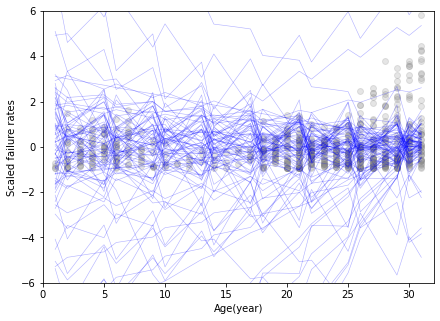

In [165]:
print(len(new_y))
age_index, ship_index = np.where(~failure_df.isnull())
Y = failure_df.values[~failure_df.isnull()]

fig, ax = plt.subplots(figsize=(7, 5))
plt.axis([0, 32, -6, 6])
ax.set_xlabel('Age(year)')
ax.set_ylabel('Scaled failure rates')
ax.scatter(failure_df.index[age_index], Y, color='grey', alpha=0.2)
ax.plot(np.arange(1, 31 + 1), new_y, color='b', alpha=0.3, linewidth=0.6)
# ax.plot(np.arange(1, 32), new_y_bar, color='m', alpha=1, linewidth=1.5)
# ax.plot(np.arange(1, 31 + 1), y_zero_prophet[3], color='b', alpha=1, linewidth=2.5)

fig.savefig("Fig.10.png", dpi = 400)
plt.show()

In [13]:
np.std(np.concatenate(new_y))

5.3358118166076585

In [14]:
#### layer2 train y_bar ELPD


failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')
test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')

## standard scale
# u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
# s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
# failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)

## power transform
pt = PowerTransformer()
pt.fit(failure_df)
failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
pt.fit(test_failure_df)
test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)



margin_sum = []
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]


for i in range(0,91):
    if i < 5:
        j = 0
    elif i < 29:
        j=1
    elif i < 71:
        j=2
    elif i < 87:
        j=3
    elif i >= 87:
        j=4    

    y_bar_mu = ((y_bar_prophet[j][0] * ((wy_bar) / (wy_sum))) +  # layer2
         (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) +  # layer1
        y_bar_prophet[j][1])  # y_prophet[i][1] : layer3 seasonality(yearly)
    y_sigma = y_bar_prophet[j][2] # layer3 sigma_obs

#     y_mu2 = pd.DataFrame({'y': failure_df.iloc[:,i], 'yhat':y_bar_mu}).dropna()
    y_mu2 = pd.DataFrame({'y': failure_df.iloc[:,i], 'yhat':y_bar_prophet[j][3]}).dropna()
    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2.y, y_mu2.yhat, y_sigma)
    # print(f'{i}', np.sum(margin_lik))
    margin_sum.append(np.mean(margin_lik))
    new_y = np.array(new_y).transpose()
# print(((margin_sum)))

print(1, np.mean(margin_sum[0:5]))
print(2,np.mean(margin_sum[5:33]))
print(3,np.mean(margin_sum[29:71]))
print(4,np.mean(margin_sum[71:87]))
print(5,np.mean(margin_sum[87:91]))
print()
print(1, np.mean(compare_y[0:5]))
print(1, np.mean(compare_y[5:33]))
print(1, np.mean(compare_y[29:71]))
print(1, np.mean(compare_y[71:87]))
print(1, np.mean(compare_y[87:91]))

1 -2.4582841839020904
2 -2.4437939238353192
3 -2.489869347371037
4 -3.2954268920241594
5 -3.74178714794734

1 1.00008403727118
1 0.9997565780326111
1 0.9905065817764483
1 1.0544821712772074
1 1.1447655589730323


In [15]:
# layer2 y_bar test set table 3 type 1~5

test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')
        

#### power transform
pt = PowerTransformer()
pt.fit(test_failure_df)
test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

from scipy.stats import norm
margin_sum = []
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]
wy_sum=[]

for j in range(0, 5):
    wy_bar = 1/y_bar_prophet[j][2]**2  # 1/layer2 sigma_obs
    wy_zero = 1/y_zero_prophet[2]**2
    wy_sum = wy_bar + wy_zero

    y_bar_mu = ((y_bar_prophet[j][0] * ((wy_bar) / (wy_sum))) +  # layer2
         (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) +  # layer1
        y_bar_prophet[j][1])  # y_prophet[i][1] : layer3 seasonality(yearly)
    y_sigma = y_bar_prophet[j][2] # layer3 sigma_obs

    y_mu2 = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_bar_mu}).dropna()
#     y_mu2 = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_bar_prophet[0][3]}).dropna()
    
    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2.y, y_mu2.yhat, y_sigma)
    print(f'{j+1}', np.mean(margin_lik))
    margin_sum.append(np.sum(margin_lik))
    new_y = np.array(new_y).transpose()
        
print(np.mean(margin_sum))
# print((compare_y))


1 -2.5317380668306635
2 -3.0830252146305965
3 -2.4521005019045887
4 -3.5193441350330277
5 -1.6642403171485693
-16.112210132740532


In [16]:
# y_zero

test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')

# def predict_prophet(s):
#     ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
#     training_df = pd.DataFrame({'ds': ds, 'y': s})
#     m = Prophet()
#     m.fit(training_df)
#     predict_df = pd.DataFrame({'ds': ds})
#     return m.predict(predict_df)['trend'],m.predict(predict_df)['yearly'],m.stan_backend.stan_fit['sigma_obs'],m.predict(predict_df)['yhat']

# y_zero_prophet = predict_prophet(failure_df.mean(axis=1).values)
# y_bar_prophet = []
# y_prophet = []
# for i in range(1, 6):
#     ships = engine_df.index[engine_df['engine'] == i]
#     y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
#     for j in range(0,len(ships)):
#         y_prophet.append(predict_prophet(failure_df[ships[j]].values))
#         print(ships[j])
        

#### power transform
pt = PowerTransformer()
pt.fit(test_failure_df)
test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

from scipy.stats import norm
margin_sum = []
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]
wy_sum=[]

for j in range(5, 10):
    wy_zero = 1/y_zero_prophet[2]**2
    wy_sum = wy_zero

    y_zero_mu = (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) + y_zero_prophet[1]
    y_sigma = y_zero_prophet[2] # layer3 sigma_obs

#     y_mu2 = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_zero_mu}).dropna()
    y_mu2 = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_zero_prophet[3]}).dropna()
    
    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2.y, y_mu2.yhat, y_sigma)
    print(f'{j+1}', np.mean(margin_lik))
    margin_sum.append(np.mean(margin_lik))
    new_y = np.array(new_y).transpose()
# print(np.mean(margin_sum))
# print((compare_y))

# from scipy.stats import norm
# for j in range(5,10):
#     margin_lik=[]
# #     z = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_bar_mu}).dropna().reset_index()
# #     z = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_bar_prophet[0][3]}).dropna().reset_index()
#     z = pd.DataFrame({'y':test_failure_df.iloc[:,j], 'yhat':y_zero_prophet[3]}).dropna().reset_index()    
#     for i in range(z.shape[0]):
# #         margin_lik.append(np.mean(norm.logpdf(z.y[i], z.yhat[i], y_bar_prophet[j][2])))    
#         margin_lik.append(np.mean(norm.logpdf(z.y[i], z.yhat[i], y_zero_prophet[2])))    
#     print(np.mean(margin_lik))
    



6 -4.858748376444586
7 -5.1454227879409995
8 -5.165168584716597
9 -5.025801529398867
10 -4.84731270988019


In [17]:
y_mu2

,y,yhat
14,-1.854364,-0.122517
15,0.512508,-0.116673
16,-0.512053,-0.112801
17,1.521403,-0.083936
18,0.786642,-0.076113
19,-0.789172,-0.070270
20,-0.311462,-0.066398
21,0.130780,-0.037533
22,-0.564900,-0.029710
23,1.467936,-0.023866


In [18]:
# len(new_y)
# age_index, ship_index = np.where(~failure_df.isnull())
# Y = failure_df.values[~failure_df.isnull()]

# fig, ax = plt.subplots(figsize=(7, 5))
# plt.axis([0, 31, -7, 7])
# ax.set_xlabel('age')
# ax.set_ylabel('failures')
# ax.scatter(failure_df.index[age_index], Y, color='grey', alpha=0.2)
# ax.plot(np.arange(1, 31 + 1), new_y, color='g', alpha=0.3, linewidth=0.6)
# ax.plot(np.arange(1, 32), new_y_bar, color='b', alpha=1, linewidth=1)
# ax.plot(np.arange(1, 31 + 1), y_zero_prophet[3], color='r', alpha=1, linewidth=2)
# plt.show()

In [19]:
test_failure_df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
age,,,,,,,,,,
1,NaN,NaN,NaN,-1.635340,1.239125,NaN,-0.163293,0.968719,-0.992696,NaN
2,NaN,NaN,NaN,-0.943078,-0.029285,NaN,-1.407551,-0.281438,-1.291941,NaN
3,NaN,NaN,NaN,-0.246146,NaN,NaN,0.169646,1.889487,1.579877,NaN
4,NaN,NaN,NaN,1.313547,-1.209840,NaN,1.401198,-0.479641,0.597833,NaN
5,NaN,NaN,NaN,0.095306,NaN,NaN,NaN,-1.399182,0.512409,NaN
6,NaN,NaN,NaN,1.273131,NaN,NaN,NaN,-1.666003,0.309040,NaN
7,-0.622941,NaN,NaN,0.142581,NaN,NaN,NaN,0.250822,-1.177722,NaN
8,1.385812,NaN,NaN,NaN,NaN,NaN,NaN,0.250822,-1.177722,NaN
9,1.127390,NaN,NaN,NaN,NaN,NaN,NaN,-0.094121,0.738035,NaN


In [20]:
# elpd
# -5.795549313791336 -23.18819749716854 -5.324164207414657 -7.846655990109608

# comp=[1.1059518361106,1.104951582403177,1.104375108654526, 1.104044995974979]

In [21]:
forecast = []
def margin_lik(m, df):
    from scipy.stats import norm
    df = df.dropna()
    m = Prophet()
    m.fit(df) 
    future = m.make_future_dataframe(periods = 30, freq='12M')
    forecast = m.predict(future)
#     print(forecast)
#     plt.plot(forecast, label = 'df')
#     plt.legend()
    y_mu = forecast.yhat
    y_sigma = m.stan_backend.stan_fit['sigma_obs']
    print(m.stan_backend.stan_fit)
    margin_lik = norm.logpdf(y_mu, y_sigma)
    return np.sum(margin_lik)

# print(margin_lik(m, df))
# print(margin_lik(m, df2))
print(margin_lik(m, df3))
forecast

NameError: name 'm' is not defined

## prophet

In [ ]:
failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')

test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')


# power transform
pt = PowerTransformer()
pt.fit(failure_df)
failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
pt.fit(test_failure_df)
test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

In [ ]:
%%time
# 데이터 2개 이하는 prophet 불가 
# type1 제외 : s4
# type2 제외 : s7,s10,s16
# type3 제외 : s60
# type4 제외 : s88, s92, s95
from fbprophet import Prophet

def predict_prophet(s):
    ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
    training_df = pd.DataFrame({'ds': ds, 'y': s})
    m = Prophet()
    m.fit(training_df)
    predict_df = pd.DataFrame({'ds': ds})
    return m.predict(predict_df)['trend'],m.predict(predict_df)['yearly'],m.stan_backend.stan_fit['sigma_obs'],m.predict(predict_df)['yhat']

y_zero_prophet = predict_prophet(failure_df.mean(axis=1).values)
y_bar_prophet = []
y_prophet = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
    for j in range(0,len(ships)):
        y_prophet.append(predict_prophet(failure_df[ships[j]].values))
        print(ships[j])


In [ ]:
y_zero_prophet

In [ ]:
from scipy.stats import norm
margin_sum = []
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]

# for i in range(0,len(y_prophet)):
for i in range(0,91):
    if i < 5:
        j = 0
    elif i < 29:
        j=1
    elif i < 71:
        j=2
    elif i < 87:
        j=3
    elif i >= 87:
        j=4    

#     wy = 1/y_prophet[i][2]**2          # 1/layer3 sigma_obs
#     wy_bar = 1/y_bar_prophet[j][2]**2  # 1/layer2 sigma_obs
#     wy_zero = 1/y_zero_prophet[2]**2   # 1/layer1 sigma_obs
#     wy_sum = wy + wy_bar + wy_zero
    
    y_mu = ((y_prophet[i][0] + y_prophet[i][1]))  # y_prophet[i][1] : layer3 seasonality(yearly)
        
    new_y.append(y_mu)
    y_sigma = y_prophet[i][2] # layer3 sigma_obs
    
#     y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_mu}).dropna()
    y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_prophet[i][3]}).dropna()
    
    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2, y_sigma)
#     print(f'{i}', np.sum(margin_lik))
    margin_sum.append(np.sum(margin_lik))


new_y = np.array(new_y).transpose()
print(np.sum(margin_sum))
print(np.mean(compare_y))


In [ ]:
from scipy.stats import norm
margin_sum = []
new_y = []
new_y_bar =[]
compare_y =[]
compare_y_bar =[]
test_compare_y =[]
test_compare_y_bar =[]

# for i in range(0,len(y_prophet)):
for i in range(0,91):
    if i < 5:
        j = 0
    elif i < 29:
        j=1
    elif i < 71:
        j=2
    elif i < 87:
        j=3
    elif i >= 87:
        j=4    

### Layer 3 ###        
#     wy = 1/y_prophet[i][2]**2          # 1/layer3 sigma_obs
#     wy_bar = 1/y_bar_prophet[j][2]**2  # 1/layer2 sigma_obs
#     wy_zero = 1/y_zero_prophet[2]**2   # 1/layer1 sigma_obs
#     wy_sum = wy + wy_bar + wy_zero
    
#     y_mu = ((y_prophet[i][0] * ((wy) / (wy_sum))) +          # layer3
#             (y_bar_prophet[j][0] * ((wy_bar) / (wy_sum))) +  # layer2
#              (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) +  # layer1
#             y_bar_prophet[i][1])  # y_prophet[i][1] : layer3 seasonality(yearly)

### Layer 2 ###
    wy = 1/y_prophet[i][2]**2          # 1/layer3 sigma_obs
    wy_bar = 1/y_bar_prophet[j][2]**2  # 1/layer2 sigma_obs
    wy_zero = 1/y_zero_prophet[2]**2   # 1/layer1 sigma_obs
    wy_sum = wy_bar + wy_zero
    
    y_mu = ((y_bar_prophet[j][0] * ((wy_bar) / (wy_sum))) +  # layer2
             (y_zero_prophet[0] * ((wy_zero) / (wy_sum))) +  # layer1
            y_bar_prophet[j][1])  # y_prophet[i][1] : layer3 seasonality(yearly)    
    
#################
    
    new_y.append(y_mu)
#     y_sigma = y_prophet[i][2] # layer3 sigma_obs
    y_sigma = y_bar_prophet[j][2] # layer2 sigma_obs
    
    y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_mu}).dropna() # G-Prophet
#     y_mu2 = pd.DataFrame({'y':failure_df.iloc[:,i], 'yhat':y_bar_prophet[j][3]}).dropna() #Prophet
    
    compare_y.append(rmse(y_mu2.y, y_mu2.yhat))
    margin_lik = norm.logpdf(y_mu2.yhat, y_sigma)
#     print(f'{i}', np.sum(margin_lik))
    margin_sum.append(np.sum(margin_lik))


new_y = np.array(new_y).transpose()
print(np.sum(margin_sum))
print(np.mean(compare_y))
np.mean(margin_sum)

In [ ]:
# for i in range(0,91):
#     if i < 5:
#         j = 0
#     elif i < 29:
#         j=1
#     elif i < 71:
#         j=2
#     elif i < 87:
#         j=3
#     elif i >= 87:
#         j=4    
        
a = np.std(failure_df.iloc[:,0:5].values[~failure_df.iloc[:,0:5].isnull()])
b = np.std(failure_df.iloc[:,5:29].values[~failure_df.iloc[:,5:29].isnull()])

print(a,b)